## Importaciones necesarias

In [122]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

## Carga de archivos
Para poder ejecutar el código es necesario cargar un archivo de nombre 'Chats.csv' y el archivo 'diccionario.txt' suministrado por el equipo.

Los mismos deben ser alojados en la carpeta donde se encuentra este script.

Tener en cuenta que puede ser necesario cambiar el tipo de encoding (primera linea de la celda a continuación) y los chats deben estar en formato csv.

In [91]:
encoding = 'UTF-8'
# Se cargan los chats en un dataframe
df_chats = pd.read_csv('./Chats.csv', delimiter = ': ', encoding = encoding, on_bad_lines='skip', engine='python')

# Se separan los chats en dos columnas: una con fecha, hora y emisor y otra con el mensaje
df_chats.columns = ['hora_usuario', 'Mensaje']

# Se elimina columna con fecha, hora y emisor para hacer menos pesado el dataframe
df_chats.drop(columns = ['hora_usuario'], inplace = True)

# Se carga el diccionario
with open("./diccionario.txt", "r", encoding="utf-8") as archivo:
    diccionario = set(line.strip() for line in archivo)

## 2. Diseño

### 2.1 Preprocesamiento
En esta etapa se consideran dos enfoques:
- Preprocesar los mensajes aceptando estas imperfecciones.
- Preprocesar los mensajes de manera que se corrijan la mayoría de palabras incorrectamente redactadas.

In [92]:
def clean_text(df, column_name, diccionario = (), excluir_tildes = True):
    '''Recibe un dataframe de chats, el nombre de la columna de mensajes y un diccionario (opcional) 
    y retorna una lista de chats donde cada chat es una lista de palabras'''
    
    # Convertimos la columna al tipo de dato string
    df[column_name] = df[column_name].astype(str)

    # Convertir todo a minúsculas
    df[column_name] = df[column_name].str.lower()

    # Eliminar el carácter \u200e
    df[column_name] = df[column_name].str.replace('\u200e', '')

    # Eliminar caracteres que no son letras
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'[.,!?¿¡;:"\'\(\)\[\]{}-]', '', x))

    # Realizar sustituciones de patrones de texto
    sustituciones = {'https?\S+': '(URL)', ' xq ': ' porque ', '[Jj][Aa]{2,}': 'jaja', ' d ': ' de ', ' k ': ' que ', r'(\w)(\1{2,})': r'\1', ' bue ': ' bueno '}
    for expresion, sustitucion in sustituciones.items():
        df[column_name] = df[column_name].apply(lambda x: re.sub(expresion, sustitucion, x))

    if excluir_tildes:
        # Remplazar vocales con tilde por vocales sin tilde
        for letra_con_tilde, letra_sin_tilde in {'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u'}.items():
            df[column_name] = df[column_name].str.replace(letra_con_tilde, letra_sin_tilde)

    # Eliminamos fila de texto no limpio, luego eliminamos filas que no contengan mensajes
    df = df[~df[column_name].isin([None, 'sticker omitido', 'imagen omitida', 'audio omitido'])]
    df = df[~df[column_name].str.contains('<multimedia omitido>')]
    df = df[~df[column_name].str.contains('none')]

    # Convierte párrafos en listas "palabra1 palabra2 palabra3" -> ["palabra1", "palabra2", "palabra3"]
    df[column_name] = df[column_name].str.split()

    # Pasamos a crear una lista de listas con los chats
    lista_chats = df[column_name].values.tolist()

    if diccionario:
      # Filtrar la lista de listas X
      lista_chats = [[palabra for palabra in lista if palabra.lower() in diccionario] for lista in lista_chats]
    
    # Eliminar las listas vacías utilizando una comprensión de lista
    lista_chats = [sublista for sublista in lista_chats if sublista]
    
    return lista_chats

### 2.2 Algoritmo

Función que construye un diccionario con probabilidades condicionales y otro con probabilidades previas. Estos son los que luego se utilizan para calcular la probabilidad máxima a posteriori y definir la palabra más probable.

In [93]:
def obtener_probabilidades_condicionales(lista_chats, N, m, usar_tf_idf):
  '''A partir de una lista de mensajes, el hiperparámetro N (últimas palabras), el valor del m-estimador y el booleano usar_tf_idf
  devuelve un diccionario con las probabilidades condicionales dada cada palabra y otro con las probabilidades previas por palabra (este último
  calculado utilizando la frecuencia de cada palabra o el algoritmo tf_idf)'''
  
  # Obtención de un diccionario intermedio de frecuencia de cada palabra
  diccionario_de_frecuencias = {}
  for lista in lista_chats:
    # Recorremos cada palabra en la lista
    for palabra in lista:
      if palabra not in diccionario_de_frecuencias:
        diccionario_de_frecuencias[palabra] = 1
      else:
        # Incrementamos la frecuencia de la palabra en el diccionario
        diccionario_de_frecuencias[palabra] += 1

  # Calculo del total de palabras en la lista de chats
  total_palabras = sum(diccionario_de_frecuencias.values())
  
  # Obtención del diccionario de probabilidades previas
  probabilidades_previas = {}
  for palabra, frecuencia_palabra in diccionario_de_frecuencias.items():
    # Si se utiliza tf_idf
    if usar_tf_idf:
      tf_idf_palabra = []
      tf_palabra = []
      documentos_con_palabra = 0
      for chat in lista_chats:
        tf_palabra.append(np.log(1 + chat.count(palabra)))
        if palabra in chat:
          documentos_con_palabra += 1
      idf = np.log(documentos_con_palabra/len(lista_chats))
      for tf in tf_palabra:
        tf_idf_palabra.append(tf*idf)
      probabilidades_previas[palabra] = sum(tf_idf_palabra)/len(tf_idf_palabra)
    # Si se utiliza la frecuencia de cada palabra
    else:
      probabilidades_previas[palabra] = frecuencia_palabra/total_palabras

  # Obtención de las probabilidades condicionales
  probabilidades_condicionales = {}
  cantidad_posibles_palabras = len(diccionario_de_frecuencias)
  for chat in lista_chats:
    for palabra_hipotesis in chat:
      diccionario_por_palabra = {}
      frecuencia_palabra_hipotesis = diccionario_de_frecuencias[palabra_hipotesis]
      if palabra_hipotesis not in probabilidades_condicionales:
        probabilidades_condicionales[palabra_hipotesis] = diccionario_por_palabra
        probabilidades_condicionales[palabra_hipotesis]['P_nada'] = (m*(1/cantidad_posibles_palabras))/(frecuencia_palabra_hipotesis + m)
      indice_palabra = chat.index(palabra_hipotesis)
      # Si N es más grande que la cantidad de palabras previas en el chat se consideran todas las palabras
      if indice_palabra - N >= 0:
        palabras_previas = chat[indice_palabra - N:indice_palabra]
      else:
        palabras_previas = chat[:indice_palabra]
      # Si en el chat hay una palabra que aparece más de una vez se cuenta como una
      palabras_previas_unicas = []
      [palabras_previas_unicas.append(x) for x in palabras_previas if x not in palabras_previas_unicas]
      # Se calcula y guarda la probabilidad condicional de cada palabra dada una palabra
      for palabra_previa in palabras_previas_unicas:
        if palabra_previa in probabilidades_condicionales[palabra_hipotesis]:
          update = probabilidades_condicionales[palabra_hipotesis][palabra_previa] + 1/(frecuencia_palabra_hipotesis + m)
        update = (1 + m*(1/cantidad_posibles_palabras))/(frecuencia_palabra_hipotesis + m)
        probabilidades_condicionales[palabra_hipotesis].update({palabra_previa : update})
  return probabilidades_condicionales, probabilidades_previas

Función utilizada para predecir la siguiente palabra

In [94]:
#debemos setear el valor del hiperparámetro palabra_anteriores, que es el que determina cuántas de las palbras anteriores considerar para calcular la probabilidad a posteriori
def recomendacion_bayesiana(frase, N, usar_prob_logaritmicas, probabilidades_condicionales, probabilidades_previas):
    if N < 1 or N > 5:
        raise ValueError("El número de palabras anteriores debe estar entre 1 y 5")

    # Tomar solo la cantidad de palabras_anteriores indicadas en el hiperparámetro o menos en caso de que no haya tantas
    lista_frase = [word for phrase in frase for word in phrase.split()]

    # Si N es más grande que la cantidad de palabras previas en la frase se consideran todas las palabras
    if len(lista_frase) < N:
        lista_frase = lista_frase
    else:
        lista_frase = lista_frase[-N:]
    
    
    P = probabilidades_condicionales
    h_MAP = ""
    p_MAP = 0
    for h in P:
      prob = probabilidades_previas[h]
      P_nada = P[h]['P_nada']
      for palabra in lista_frase:
        if usar_prob_logaritmicas:
          prob = np.log(prob) + np.log(P[h].get(palabra, P_nada))
        else:
          prob = prob * P[h].get(palabra, P_nada)
      if prob > p_MAP:
        h_MAP , p_MAP = h , prob

    return h_MAP, p_MAP

### 2.3 Evaluación

Función utilizada para evaluar las palabras sugeridas y probabilidades al variar los distintos parámetros.

In [98]:
def evaluar(lista_chats_train, lista_chats_test, N, m, usar_tf_idf, usar_prob_logaritmicas):
  probabilidades_condicionales, probabilidades_previas = obtener_probabilidades_condicionales(lista_chats_train, N, m, False)
  promedios = []
  medianas = []
  for palabra_h in probabilidades_condicionales:
    valores = probabilidades_condicionales[palabra_h].values()
    n = len(valores)
    # Calcular el promedio
    promedio_valores_palabra_h = sum(valores)/n
    promedios.append(promedio_valores_palabra_h)
    # Calcular la mediana
    valores_ordenados = sorted(valores)
    if n % 2 == 0:
      mediana_valores_palabra_h = (valores_ordenados[n // 2 - 1] + valores_ordenados[n // 2]) / 2
    else:
      mediana_valores_palabra_h = valores_ordenados[n // 2]
    medianas.append(mediana_valores_palabra_h)
  promedio_prob_palabras = sum(promedios)/len(promedios)
  medianas_ordenadas = sorted(medianas)
  n_medianas = len(medianas_ordenadas)
  if n_medianas % 2 == 0:
    mediana_prob_palabras = (medianas_ordenadas[n_medianas // 2 - 1] + medianas_ordenadas[n_medianas // 2]) / 2
  else:
    mediana_prob_palabras = medianas_ordenadas[n_medianas // 2]
  palabras_sugeridas = []
  probabilidades = []
  for chat_test in lista_chats_test:
    palabra_sugerida, probabilidad = recomendacion_bayesiana(chat_test, N, usar_prob_logaritmicas, probabilidades_condicionales, probabilidades_previas)
    palabras_sugeridas.append(palabra_sugerida)
    probabilidades.append(probabilidad)
  return palabras_sugeridas, probabilidades

In [ ]:
def evaluacion_accuracy(y_verdaderas, y_estimadas):
  predicciones_correctas = 0
  total_predicciones = len(y_verdaderas)

  # Compara las predicciones con las etiquetas verdaderas
  for palabra_real, palabra_estimada in zip(y_verdaderas, y_estimadas):
      if palabra_real == palabra_estimada:
          predicciones_correctas += 1

  # Calcula la precisión
  return predicciones_correctas / total_predicciones * 100

### 3. Experimentación

In [108]:
lista_chats_lang_flexible = clean_text(df_chats, 'Mensaje', diccionario = (), excluir_tildes = True)
lista_chats_lang_correcto_excluyendo_tildes = clean_text(df_chats, 'Mensaje', diccionario = diccionario, excluir_tildes = True)
lista_chats_lang_correcto = clean_text(df_chats, 'Mensaje', diccionario = diccionario, excluir_tildes = False)

# Genero aleatoriedad en el orden de los chats
seed_value = 42
np.random.seed(seed_value)
np.random.shuffle(lista_chats_lang_flexible)
np.random.shuffle(lista_chats_lang_correcto_excluyendo_tildes)
np.random.shuffle(lista_chats_lang_correcto)

# Defino las proporciones de chats_train y val
tamanio_chats_flexible = len(lista_chats_lang_flexible)
tamanio_chats_correcto_excluyendo_tildes = len(lista_chats_lang_correcto_excluyendo_tildes)
tamanio_chats_correcto = len(lista_chats_lang_correcto)

train_prop = 0.7
val_prop = 0.1

# Calculo el tamaño de cada set
tamanio_train_flexible = int(train_prop * tamanio_chats_flexible)
tamanio_val_flexible = int(val_prop * tamanio_chats_flexible)
tamanio_train_correcto_excluyendo_tildes = int(train_prop * tamanio_chats_correcto_excluyendo_tildes)
tamanio_val_correcto_excluyendo_tildes = int(val_prop * tamanio_chats_correcto_excluyendo_tildes)
tamanio_train_correcto = int(train_prop * tamanio_chats_correcto)
tamanio_val_correcto = int(val_prop * tamanio_chats_correcto)

# Divido los chats en train, validacion y test
train_flexible = lista_chats_lang_flexible[:tamanio_train_flexible]
val_flexible = lista_chats_lang_flexible[tamanio_train_flexible:tamanio_train_flexible + tamanio_val_flexible]
test_flexible = lista_chats_lang_flexible[tamanio_train_flexible + tamanio_val_flexible:]
train_correcto_excluyendo_tildes = lista_chats_lang_flexible[:tamanio_train_correcto_excluyendo_tildes]
val_correcto_excluyendo_tildes = lista_chats_lang_flexible[tamanio_train_correcto_excluyendo_tildes:tamanio_train_correcto_excluyendo_tildes + tamanio_val_correcto_excluyendo_tildes]
test_correcto_excluyendo_tildes = lista_chats_lang_flexible[tamanio_train_correcto_excluyendo_tildes + tamanio_val_correcto_excluyendo_tildes:]
train_correcto = lista_chats_lang_correcto[:tamanio_train_correcto]
val_correcto = lista_chats_lang_correcto[tamanio_train_correcto:tamanio_train_correcto + tamanio_val_correcto]
test_correcto = lista_chats_lang_correcto[tamanio_train_correcto + tamanio_val_correcto:]

In [109]:
# Divido los sets de test quedandome con la última palabra de cada chat para luego evaluar si es predecida correctamente
# Se obtiene la primera lista con todos los elementos excepto el último
val_flexible_palabras_previas = [sublista[:-1] for sublista in val_flexible]
val_correcto_excluyendo_tildes_palabras_previas = [sublista[:-1] for sublista in val_correcto_excluyendo_tildes]
val_correcto_palabras_previas = [sublista[:-1] for sublista in val_correcto]
test_flexible_palabras_previas = [sublista[:-1] for sublista in test_flexible]
test_correcto_excluyendo_tildes_palabras_previas = [sublista[:-1] for sublista in test_correcto_excluyendo_tildes]
test_correcto_palabras_previas = [sublista[:-1] for sublista in test_correcto]

# Se obtiene la segunda lista con solo los últimos elementos
val_flexible_ultima_palabra = [sublista[-1] for sublista in val_flexible]
val_correcto_excluyendo_tildes_ultima_palabra = [sublista[-1] for sublista in val_correcto_excluyendo_tildes]
val_correcto_ultima_palabra = [sublista[-1] for sublista in val_correcto]
test_flexible_ultima_palabra = [sublista[-1] for sublista in test_flexible]
test_correcto_excluyendo_tildes_ultima_palabra = [sublista[-1] for sublista in test_correcto_excluyendo_tildes]
test_correcto_ultima_palabra = [sublista[-1] for sublista in test_correcto]

In [110]:
palabras_estimadas_lang_flexible, probabilidades_lang_flexible = evaluar(train_flexible, val_flexible_palabras_previas, 1, 1, False, False)
palabras_estimadas_lang_correcto_excluyendo_tildes, probabilidades_lang_correcto_excluyendo_tildes = evaluar(train_correcto_excluyendo_tildes, val_correcto_excluyendo_tildes_palabras_previas, 1, 1, False, False)
palabras_estimadas_lang_correcto, probabilidades_lang_correcto = evaluar(train_correcto, val_correcto_palabras_previas, 1, 1, False, False)
# evaluacion_accuracy
accuracy_lang_flexible = evaluacion_accuracy(val_flexible_ultima_palabra, palabras_estimadas_lang_flexible)
accuracy_lang_correcto_excluyendo_tildes = evaluacion_accuracy(val_correcto_excluyendo_tildes_ultima_palabra, palabras_estimadas_lang_correcto_excluyendo_tildes)
accuracy_lang_correcto = evaluacion_accuracy(val_correcto_ultima_palabra, palabras_estimadas_lang_correcto)

print(f'Accuracy utilizando lenguaje flexible: {accuracy_lang_flexible}')
print(f'Accuracy utilizando lenguaje correcto: {accuracy_lang_correcto_excluyendo_tildes}')
print(f'Accuracy utilizando lenguaje correcto: {accuracy_lang_correcto}')


Accuracy utilizando lenguaje flexible: 0.57356608478803
Accuracy utilizando lenguaje correcto: 0.6524317912218268
Accuracy utilizando lenguaje correcto: 1.3641755634638197


In [107]:
palabras_estimadas_N1, probabilidades_N1 = evaluar(train_correcto, val_correcto_palabras_previas, 1, 1, False, False)
palabras_estimadas_N2, probabilidades_N2 = evaluar(train_correcto, val_correcto_palabras_previas, 2, 1, False, False)
palabras_estimadas_N3, probabilidades_N3 = evaluar(train_correcto, val_correcto_palabras_previas, 3, 1, False, False)
palabras_estimadas_N4, probabilidades_N4 = evaluar(train_correcto, val_correcto_palabras_previas, 4, 1, False, False)

# evaluacion_accuracy
accuracy_N1 = evaluacion_accuracy(val_correcto_ultima_palabra, palabras_estimadas_N1)
accuracy_N2 = evaluacion_accuracy(val_correcto_ultima_palabra, palabras_estimadas_N2)
accuracy_N3 = evaluacion_accuracy(val_correcto_ultima_palabra, palabras_estimadas_N3)
accuracy_N4 = evaluacion_accuracy(val_correcto_ultima_palabra, palabras_estimadas_N4)

print(f'Accuracy utilizando lenguaje correcto y N = 1: {accuracy_N1}')
print(f'Accuracy utilizando lenguaje correcto y N = 2: {accuracy_N2}')
print(f'Accuracy utilizando lenguaje correcto y N = 3: {accuracy_N3}')
print(f'Accuracy utilizando lenguaje correcto y N = 4: {accuracy_N4}')


Accuracy utilizando lenguaje correcto y N = 1: 1.3641755634638197
Accuracy utilizando lenguaje correcto y N = 2: 1.3938315539739028
Accuracy utilizando lenguaje correcto y N = 3: 1.3345195729537367
Accuracy utilizando lenguaje correcto y N = 4: 1.0379596678529062


In [111]:
palabras_unicas = set()

# Itera a través de las listas de palabras y agrega cada palabra al conjunto
for lista in train_correcto:
    for palabra in lista:
        palabras_unicas.add(palabra)

# Calcula la cantidad de palabras únicas
cantidad_palabras_unicas = len(palabras_unicas)

palabras_estimadas_m1, probabilidades_m1 = evaluar(train_correcto, val_correcto_palabras_previas, 2, 1, False, False)
palabras_estimadas_m5, probabilidades_m5 = evaluar(train_correcto, val_correcto_palabras_previas, 2, 5, False, False)
palabras_estimadas_m_cant_palabras, probabilidades_m_cant_palabras = evaluar(train_correcto, val_correcto_palabras_previas, 2, cantidad_palabras_unicas, False, False)

# evaluacion_accuracy
accuracy__m1 = evaluacion_accuracy(val_correcto_ultima_palabra, palabras_estimadas_m1)
accuracy_m5 = evaluacion_accuracy(val_correcto_ultima_palabra, palabras_estimadas_m5)
accuracy_m_cant_palabras = evaluacion_accuracy(val_correcto_ultima_palabra, palabras_estimadas_m_cant_palabras)

print(f'Accuracy utilizando m = 1: {accuracy__m1}')
print(f'Accuracy utilizando m = 5: {accuracy_m5}')
print(f'Accuracy utilizando m = cantidad de posibles palabras: {accuracy_m_cant_palabras}')


Accuracy utilizando m = 1: 1.3938315539739028
Accuracy utilizando m = 5: 1.5124555160142348
Accuracy utilizando m = cantidad de posibles palabras: 0.8896797153024912


In [112]:
palabras_estimadas_tf_idf, probabilidades_tf_idf = evaluar(train_correcto, val_correcto_palabras_previas, 2, 5, True, False)
palabras_estimadas_prob_logaritmicas, probabilidades_prob_logaritmicas = evaluar(train_correcto, val_correcto_palabras_previas, 2, 5, False, True)
palabras_estimadas_tf_idf_prob_logaritmicas, probabilidades_tf_idf_prob_logaritmicas = evaluar(train_correcto, val_correcto_palabras_previas, 2, 5, True, True)

# evaluacion_accuracy
accuracy_tf_idf = evaluacion_accuracy(val_correcto_ultima_palabra, palabras_estimadas_tf_idf)
accuracy_prob_logaritmicas = evaluacion_accuracy(val_correcto_ultima_palabra, palabras_estimadas_prob_logaritmicas)
accuracy_tf_idf_prob_logaritmicas = evaluacion_accuracy(val_correcto_ultima_palabra, palabras_estimadas_tf_idf_prob_logaritmicas)

print(f'Accuracy utilizando tf-idf: {accuracy_tf_idf}')
print(f'Accuracy utilizando probabilidades logarítmicas: {accuracy_prob_logaritmicas}')
print(f'Accuracy utilizando tf-idf y probabilidades logarítmicas: {accuracy_tf_idf_prob_logaritmicas}')

/var/folders/j4/fqqffb5178563_mtw59pydpw0000gn/T/ipykernel_82555/3008170168.py:24: RuntimeWarning: invalid value encountered in log
  prob = np.log(prob) + np.log(P[h].get(palabra, P_nada))


Accuracy utilizando tf-idf: 1.5124555160142348
Accuracy utilizando probabilidades logarítmicas: 0.05931198102016608
Accuracy utilizando tf-idf y probabilidades logarítmicas: 0.05931198102016608


In [114]:
valores_accuracy = []
for m in range(1, cantidad_palabras_unicas, cantidad_palabras_unicas//10):
    palabras_estimadas, probabilidades = evaluar(train_correcto, val_correcto_palabras_previas, 2, m, False, False)
    accuracy = evaluacion_accuracy(val_correcto_ultima_palabra, palabras_estimadas)
    valores_accuracy.append(accuracy)
    print(f'Accuracy utilizando m = {m}: {accuracy}')

Accuracy utilizando m = 1: 1.3938315539739028
Accuracy utilizando m = 948: 0.8896797153024912
Accuracy utilizando m = 1895: 0.9193357058125742
Accuracy utilizando m = 2842: 1.1269276393831553
Accuracy utilizando m = 3789: 1.601423487544484
Accuracy utilizando m = 4736: 1.482799525504152
Accuracy utilizando m = 5683: 0.9786476868327402
Accuracy utilizando m = 6630: 0.9489916963226572
Accuracy utilizando m = 7577: 0.9489916963226572
Accuracy utilizando m = 8524: 0.9193357058125742
Accuracy utilizando m = 9471: 0.8896797153024912


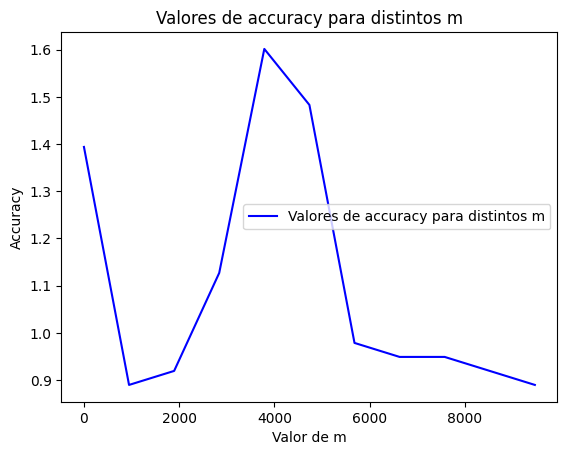

In [124]:
plt.plot(range(1, cantidad_palabras_unicas, cantidad_palabras_unicas//10), valores_accuracy, label="Valores de accuracy para distintos m", color="blue", linestyle="-")

plt.title("Valores de accuracy para distintos m")
plt.xlabel("Valor de m")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [117]:
valores_accuracy_2 = []
for m in range(1, 500, 25):
    palabras_estimadas, probabilidades = evaluar(train_correcto, val_correcto_palabras_previas, 2, m, False, False)
    accuracy = evaluacion_accuracy(val_correcto_ultima_palabra, palabras_estimadas)
    valores_accuracy_2.append(accuracy)
    print(f'Accuracy utilizando m = {m}: {accuracy}')

Accuracy utilizando m = 1: 1.3938315539739028
Accuracy utilizando m = 26: 1.3345195729537367
Accuracy utilizando m = 51: 1.3048635824436536
Accuracy utilizando m = 76: 1.7200474495848161
Accuracy utilizando m = 101: 1.8683274021352312
Accuracy utilizando m = 126: 1.8683274021352312
Accuracy utilizando m = 151: 1.5124555160142348
Accuracy utilizando m = 176: 1.4234875444839856
Accuracy utilizando m = 201: 1.0676156583629894
Accuracy utilizando m = 226: 0.9193357058125742
Accuracy utilizando m = 251: 1.2158956109134045
Accuracy utilizando m = 276: 1.3641755634638197
Accuracy utilizando m = 301: 1.2752075919335706
Accuracy utilizando m = 326: 1.2455516014234875
Accuracy utilizando m = 351: 1.3641755634638197
Accuracy utilizando m = 376: 1.2752075919335706
Accuracy utilizando m = 401: 1.3641755634638197
Accuracy utilizando m = 426: 1.453143534994069
Accuracy utilizando m = 451: 1.0676156583629894
Accuracy utilizando m = 476: 1.0972716488730723


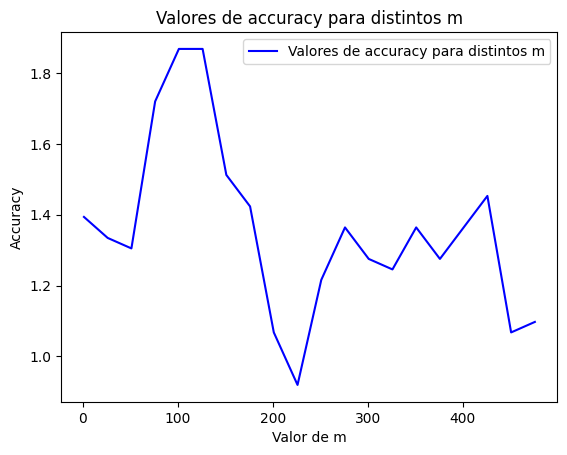

In [123]:
plt.plot(range(1, 500, 25), valores_accuracy_2, label="Valores de accuracy para distintos m", color="blue", linestyle="-")

plt.title("Valores de accuracy para distintos m")
plt.xlabel("Valor de m")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### Evaluación en set de testeo

In [126]:
palabras_estimadas_test, probabilidades_test = evaluar(train_correcto, test_correcto_palabras_previas, 2, 100, False, False)

# evaluacion_accuracy
accuracy_test = evaluacion_accuracy(test_correcto_ultima_palabra, palabras_estimadas_test)

print(f'Accuracy utilizando conjunto de datos de testeo: {accuracy_test}')

Accuracy utilizando conjunto de datos de testeo: 1.4825796886582654


### Función cliente con la que se puede simular el comportamiento del algoritmo para predecir la siguiente palabra y reentrenar el algoritmo

In [135]:
##### LOOP PRINCIPAL #####
N = 2
probabilidades_condicionales, probabilidades_previas = obtener_probabilidades_condicionales(lista_chats_lang_correcto, 2, 100, False)
print("Ingrese la frase dando ENTER luego de \x1b[3mcada palabra\x1b[0m.")
print("Ingrese sólo ENTER para aceptar la recomendación sugerida, o escriba la siguiente palabra y de ENTER")
print("Ingrese '.' para comenzar con una frase nueva.")
print("Ingrese '..' para terminar el proceso.")

frase = []
palabra_sugerida = ""
while 1:
    palabra = input(">> ")

    if palabra == "..":
      break

    elif palabra == ".":
      print("----- Comenzando frase nueva -----")
      #Con esto el algoritmo aprende, agregamos nuevas frases que el algoritmo utilizará
      lista_frase = [word for phrase in frase for word in phrase.split()]
      lista_chats_lang_correcto.append(lista_frase)
      probabilidades_condicionales, probabilidades_previas = obtener_probabilidades_condicionales(lista_chats_lang_correcto, 2, 100, False)
      frase = []

    elif palabra == "": # acepta última palabra sugerida
      frase.append(palabra_sugerida)

    else: # escribió una palabra
      frase.append(palabra)

    if frase:
      palabra_sugerida, probabilidad = recomendacion_bayesiana(frase, N, False, probabilidades_condicionales, probabilidades_previas)

      frase_propuesta = frase.copy()
      frase_propuesta.append("\x1b[3m"+ palabra_sugerida +"\x1b[0m")
      print(" ".join(frase_propuesta))
      print(f'Probabilidad de la palabra propuesta: {probabilidad}')

Ingrese la frase dando ENTER luego de cada palabra.
Ingrese sólo ENTER para aceptar la recomendación sugerida, o escriba la siguiente palabra y de ENTER
Ingrese '.' para comenzar con una frase nueva.
Ingrese '..' para terminar el proceso.
hola como estan ustedes
Probabilidad de la palabra propuesta: 1.4347756161162903e-08
hola como estan ustedes quieren
Probabilidad de la palabra propuesta: 1.4322846862271994e-08
hola como estan ustedes quieren pueden
Probabilidad de la palabra propuesta: 1.429915510028833e-08
hola como estan ustedes quieren pueden comer
Probabilidad de la palabra propuesta: 1.4321150354311999e-08
----- Comenzando frase nueva -----
